In [1]:
## Import libraries for calculation functions

import inspect
import pandas as pd
import numpy as np
import xarray as xr
from glob import glob
from pathlib import Path
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import gamma
from scipy.interpolate import interp1d

In [2]:
## Settings for calculation functions

# This is to get the version number of the calc_funcs script being used so that it
# can be appended to the file name of any outputs. The reason this is done is because
# the calculation functions below and the plot functions in the plot_funcs script both
# output intermediate files one at a time from low level to high level, and that each
# file name is used in recognising whether there is a need to re-run a script (if the
# file already exists then the script is not run so as to save on computation).
# However, this method can propagate errors from low level through to high level
# if there has been a change to the code and/or output at the lower levels. By
# appending the version number of the calc_funcs script being used, it forces all
# intermediate files to be recreated from scratch rather than reuse intermediate files
# which was outputted by outdated code. "v00" is used as a placeholder version number
# if there is an error: it is used mostly for scripting purposes within an
# interactive python notebook where the file name cannot be directly extracted
# using the __file__ python variable.
try:
    calc_funcs_ver = Path(__file__).stem[-3:]
except:
    calc_funcs_ver = "v00"

# Valid regions and their mapping to axis extents in [W, E, S, N] format 
# as well as timezones in hour +- GMT
regions = {
    # Central America (mostly Honduras-Nicaragua-Costa Rica)
    "ca": {"extent": [-91, -81, 7, 17], "tz": -6},
    # South America (mostly central and eastern Brazil)
    "sa": {"extent": [-65, -30, -15, 0], "tz": -3},
    # Western Australia (mostly near the west coast)
    "wa": {"extent": [113, 123, -35, -30], "tz": +8}
}

# Earliest and latest entries in each GLASS dataset
avhrr_earliest = "Jan-1981"
modis_earliest = "Mar-2000"
avhrr_latest = "Dec-2018"
modis_latest = "Dec-2021"
fapar_earliest = "Jan-1982"
fapar_latest = "Dec-2020"

# Size of chunks
chunksize = "500MB"

# Valid subsets to use as argument in climatologies and
# their mapping to month numbers for use in xarray time slicing
subsets = {
    "all": [1,2,3,4,5,6,7,8,9,10,11,12],
    "DJF": [12,1,2], "MAM": [3,4,5], "JJA": [6,7,8], "SON": [9,10,11],
    "Jan": [1], "Feb": [2], "Mar": [3], "Apr": [4], "May": [5], "Jun": [6],
    "Jul": [7], "Aug": [8], "Sep": [9], "Oct": [10], "Nov": [11], "Dec": [12]
}

# Valid variables for use in analysis
hours = list(range(0, 24))
vars_glass = ["lai", "fapar"]
vars_era5 = {
    "vars": {
        "surface": ["wv10", "wv100", "mslp", "t2", "slhf", "sshf"],
        "atmos": ["viec", "vipile", "vike", "tcclw", "tcwv", "nac"]
    },
    "dvars": {
        "surface": ["dwv10", "dwv100", "dmslp", "dt2", "dslhf", "dsshf"],
        "atmos": ["dviec", "dvipile", "dvike", "dtcclw", "dtcwv", "dnac"]
    }
}
vars_and_dvars_era5_all = []
for var_type, var_dict in vars_era5.items():
    for var_level, var_list in var_dict.items():
        for var_or_dvar in var_list:
            vars_and_dvars_era5_all.append(var_or_dvar)

# Mapping from ERA5 dataset variable names to own desired names, while
# implicitly accounting for any var_or_dvar variable dependencies
vars_rename = {"wv10": {"u10": "u10", "v10": "v10"},
               "wv100": {"u100": "u100", "v100": "v100"},
               "mslp": {"msl": "mslp"},
               "t2": {"t2m": "t2"},
               "slhf": {"slhf": "slhf"},
               "sshf": {"sshf": "sshf"},
               "viec": {"p64.162": "viec"},
               "vipile": {"p62.162": "vipile"},
               "vike": {"p59.162", "vike"},
               "tcclw": {"tclw": "tcclw"},
               "tcwv": {"tcwv": "tcwv"},
               "nac": {"e": "nse", "p84.162": "vidmf", "p80.162": "vidcfwf",
                       "p79.162": "vidclwf", "tcwv": "tcwv"}
              }

# File number check to make sure data_download notebook was run correctly
number_of_glass_files = {"lai": {"avhrr": 1748, "modis": 1005},
                         "fapar": {"avhrr": 1702, "modis": 960}
                        }
number_of_era5_month_hour_files = 42
number_of_era5_hour_files = 42

# Resolution of ERA5 dataset in degrees (used for regridding)
res_era5 = 0.25

# Speed (in m/s) for expected rate of exceedance analysis at 100 m
speed_eroe = 42.5

# Typical power curve for a 100 m turbine with 100 m rotor diameter and 
# a nameplate rating of around 2500 kW (used to compute gross capacity factor)
# Speeds are in m/s, powers are in kW, data from https://www.thewindpower.net
speeds_common = np.append(np.linspace(0, 25.5, 52), 999)
power_nameplate = 2500
# Vestas V100/2600
powers_vestas = np.array([0, 0, 0, 0, 0, 0, 21, 63, 115, 172, 239, 318, 405, 550,
                          706, 890, 1080, 1283, 1485, 1641, 1796, 1944, 2092, 2225,
                          2351, 2440, 2502, 2560, 2584, 2597, 2600, 2600, 2600,
                          2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600,
                          2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600, 0, 0])
# Goldwind GW100/2500
powers_gw = np.array([0, 0, 0, 0, 0, 6, 34, 65, 101, 165, 235, 320, 409, 530, 655,
                      826, 997, 1196, 1394, 1669, 1943, 2170, 2313, 2415, 2458,
                      2485, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 0, 0])
# GE Energy 2.5-100
powers_ge = np.array([0, 0, 0, 0, 0, 0, 10, 80, 160, 250, 340, 460, 590, 770, 952,
                      1170, 1389, 1650, 1869, 2100, 2260, 2400, 2487, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 0, 0])
# Average
powers_avg = (powers_vestas/26*25 + powers_gw + powers_ge) / 3

# Names of calculation functions
calc_func_names = ["calc_glass_mean_climatology",
                   "calc_era5_mdp_climatology_given_var_or_dvar",
                   "calc_era5_mdp_climatology_stats_given_var_or_dvar",
                   "calc_era5_mdp_climatology_values_given_var_or_dvar_and_hour",
                   "calc_era5_wsd_climatology"]

In [3]:
## Supplementary functions for calculation functions

def check_args(calc_func=None, region=None, period_start=None, period_end=None,
               subset=None, var_or_dvar=None, hour=None,
               vars_level=None, vars_type=None):
    
    """
    Function to check whether input arguments are valid.
    
    Arguments:
        calc_func (function): Calculation function to compute difference in
            results from. Must be one of: ["calc_glass_mean_climatology",
            "calc_era5_mdp_climatology_given_var_or_dvar",
            "calc_era5_mdp_climatology_stats_given_var_or_dvar",
            "calc_era5_mdp_climatology_values_given_var_or_dvar_and_hour",
            "calc_era5_wsd_climatology"].
        region (str): Region to perform calculation over.
            Must be one of: ["ca", "sa", "wa"].
        period1_start (datetime.datetime): Start of first period to perform
            calculation over. Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
            Note that this is a datetime.dateime object as opposed to str.
        period1_end (datetime.datetime): End of first period to perform
            calculation over. Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
            Note that this is a datetime.dateime object as opposed to str.
        period2_start (datetime.datetime): Start of second period to perform
            calculation over. Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
            Note that this is a datetime.dateime object as opposed to str.
        period2_end (datetime.datetime): End of second period to perform
            calculation over. Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
            Note that this is a datetime.dateime object as opposed to str.
        subset (str): Subset of period to perform calculation over.
            Must be one of: ["all", "DJF", "MAM", "JJA", "SON",
            "Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"].
        var_or_dvar (str): Variable or value of change in variable to perform
            calculation over. Must be one of: ['wv10', 'wv100', 'mslp', 't2',
            'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 'nac',
            'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 'dsshf', 'dviec',
            'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
        hour (int): Hour of mean diurnal profile to compute value for.
            Must be one of: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
            13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23].
        vars_level (str): Level from which to draw variables for analysis.
            This is used for the plot_func script. Must be one of:
            ["surface", "atmos"].
        vars_type (str): Whether to analyse the variables themselves or the change
            in their mean diurnal profile values as compared with their values
            in the previous hour. This is used for the plot_func script.
            Must be one of: ["vars", "dvars"].            
    
    Returns:
        AssertionError if any of the input arguments are invalid.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<cell line: 1>":
        print(f"Executing: {func_cur} to check whether input arguments are valid.")
    else:
        print(f"Executing: {func_cur} to check whether input arguments into " +
              f"{func_1up} are valid.")
    
    if calc_func:
        assert calc_func.__name__ in calc_func_names, \
            f"calc_func must be one of: {calc_func_names}"    
    if region:
        assert region in [*regions], \
            f"region must be one of: {[*regions]}"
    if period_start:
        assert period_start >= datetime.strptime(avhrr_earliest, "%b-%Y"), \
            f"period_start must be equal to or later than {avhrr_earliest}"        
    if period_end:
        assert period_end <= datetime.strptime(modis_latest, "%b-%Y"), \
            f"period_end must be equal to or earlier than {modis_latest}"
    if (period_start is not None) & (period_end is not None):
        assert period_end >= period_start, \
            "period_end must be equal to or later than period_start"        
    if subset:
        assert subset in [*subsets], \
            f"subset must be one of: {[*subsets]}"
    if (period_start is not None) & (period_end is not None) & (subset is not None):
        dates_in_period = pd.date_range(period_start, period_end, freq = "MS")
        months_in_period = set(map(int, dates_in_period.strftime("%-m")))
        assert any(month in subsets[subset] for month in months_in_period), \
            "period(s) must contain at least one month within the given subset"
    if var_or_dvar:
        assert var_or_dvar in vars_and_dvars_era5_all, \
            f"var_or_dvar must be one of: {vars_and_dvars_era5_all}"
    if hour:
        assert hour in hours, \
            f"hour must be one of: {hours}"
    if vars_level:
        assert vars_level in [*[*vars_era5.values()][0].keys()], \
            f"vars_level must be one of: {[*[*vars_era5.values()][0].keys()]}"
    if vars_type:
        assert vars_type in [*vars_era5], \
            f"vars_type must be one of: {[*vars_era5]}"
    
    if func_1up == "<cell line: 1>":
        print("Passed: validity check for input arguments.")
    else:
        print(f"Passed: validity check for input arguments into {func_1up}.")

In [4]:
def glass_data_source_to_use(period_start, period_end):
    
    """
    Select which GLASS data source (AVHRR or MODIS) to use.
    
    Arguments:
        period_start (datetime.datetime): Start of period to perform calculation over.
            Note that this is a datetime.dateime object as opposed to str.
        period_end (datetime.datetime): End of period to perform calculation over.
            Note that this is a datetime.dateime object as opposed to str.
        
    Returns:
        glass_data_source (str): String indicating whether to use
            "avhrr" or "modis" data for the given period.
    
    For the given period, select the most appropriate GLASS data source to use 
    (out of AVHRR and MODIS). MODIS is preferentially selected where the given 
    period is completely contained within the time range of MODIS data. 
    Otherwise, AVHRR data is used. Periods which simultaneously cover both an 
    AVHRR-only period (i.e. before Mar-2000) and a MODIS-only period 
    (i.e. after Dec-2018) are prevented from selection since summary statistics
    over this range is subject to artefacts from the change in instruments.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<cell line: 1>":
        print(f"Executing: {func_cur} to select the appropriate " +
              "glass data source for use between {} and {}."
              .format(period_start.strftime("%b-%Y"), period_end.strftime("%b-%Y"))
             )
    else:
        print(f"Executing: {func_cur} to select the appropriate " +
              "glass data source for use between {} and {} in {}."
              .format(period_start.strftime("%b-%Y"), period_end.strftime("%b-%Y"),
                      func_1up)
             )
    
    check_args(period_start=period_start, period_end=period_end)
    
    if ((period_start >= datetime.strptime(avhrr_earliest, "%b-%Y")) & 
        (period_start < datetime.strptime(modis_earliest, "%b-%Y")) &
        (period_end <= datetime.strptime(avhrr_latest, "%b-%Y"))
       ):
        glass_data_source = "avhrr"
    elif ((period_start >= datetime.strptime(modis_earliest, "%b-%Y")) &
          (period_end <= datetime.strptime(modis_latest, "%b-%Y"))
         ):
        glass_data_source = "modis"
    else:
        raise Exception("If period_start is before Mar-2000, " +
                        "period_end cannot be after Dec-2018 " +
                        "(since this would cover both an " +
                        "AVHRR-only and a MODIS-only period)")
    
    if func_1up == "<cell line: 1>":
        print("Selected: {} glass data source for use between {} and {}."
              .format(glass_data_source, period_start.strftime("%b-%Y"),
                      period_end.strftime("%b-%Y"))
             )
    else:
        print("Selected: {} glass data source for use between {} and {} in {}."
              .format(glass_data_source, period_start.strftime("%b-%Y"),
                      period_end.strftime("%b-%Y"), func_1up)
             )
        
    return glass_data_source

In [5]:
def get_vars_level_and_type(var_or_dvar):
    
    """
    Obtain the vars_level and vars_type classification for the given var_or_dvar.
    
    Arguments:
        var_or_dvar (str): Variable or value of change in variable to perform
            calculation over. Must be one of: ['wv10', 'wv100', 'mslp', 't2',
            'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 'nac',
            'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 'dsshf', 'dviec',
            'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
    
    Returns:
        vars_level (str): vars_level classification indicating which spatial level
            var_or_dvar primarily sits in. Can be either "surface" or "atmos".
        vars_type (str): vars_type classification indicating whether var_or_dvar
            is the variable itself ("vars") or the change in the value of a
            variable as compared with the previous hour ("dvars").
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<cell line: 1>":
        print(f"Executing: {func_cur} to obtain the vars_level and vars_type " +
              f"classification of {var_or_dvar}.")
    else:
        print(f"Executing: {func_cur} to obtain the vars_level and vars_type " +
              f"classification of {var_or_dvar} for use in {func_1up}.")
    
    check_args(var_or_dvar=var_or_dvar)
    for var_type, var_dict in vars_era5.items():
        for var_level, var_list in var_dict.items():
            if var_or_dvar in var_list:
                vars_level = var_level
                vars_type = var_type
                
    if func_1up == "<cell line: 1>":
        print(f"Obtained: {var_or_dvar} classifications of {vars_level, vars_type}.")
    else:
        print(f"Obtained: {var_or_dvar} classifications of {vars_level, vars_type} " +
              f"for use in {func_1up}.")
        print(f"Executing: {func_cur} to obtain the vars_level and vars_type " +
              f"classification of {var_or_dvar} for use in {func_1up}.")
    
    return vars_level, vars_type

In [6]:
def regrid_era5(ds):
    
    """
    Regrid ERA5 xarray dataset.
    
    Arguments:
        ds (xarray.Dataset): Dataset containing ERA5 data, loaded in
            with xarray using the netcdf4 engine.
                                
    Returns:
        ds_rg (xarray.Dataset): Dataset with regridded coordinates.
        
    Shifts each latitude coordinate south and longitude coordinate east by
    half a grid cell. This reflects the fact that coordinates in the
    original ERA5 dataset defines the north-western corner of each grid
    cell, whereas xarray plots assuming the coordinates refer to the centre.
    """
    
    year_file = ds.encoding["source"][-7:-3]
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<cell line: 1>":
        print(f"Executing: {func_cur} on {year_file} file to make ERA5 " +
              "coordinates consistent with xarray plotting.")
    else:
        print(f"Executing: {func_cur} on {year_file} file to make ERA5 " +
              f"coordinates consistent with xarray plotting for use in {func_1up}.")
    
    ds_rg = (ds
            .assign_coords({"latitude": ds.latitude - res_era5/2,
                            "longitude": (ds.longitude + 180 + res_era5/2) % 360 - 180})
            # Redundant measure just in case longitudes exceed 180 degrees
            .sortby("longitude")
            )
    
    if func_1up == "<cell line: 1>":
        print(f"Regridded: ERA5 coordinates in {year_file} file.")
    else:
        print(f"Regridded: ERA5 coordinates in {year_file} file for use in {func_1up}.")
    
    return ds_rg

In [7]:
def magnitude(da_x, da_y):
    
    """
    Calculate magnitude of 2D vectors given their components.
    
    Arguments:
        da_x (xarray.DataArray): x-component of vectors.
        da_y (xarray.DataArray): y-component of vectors.
        
    Returns:
        da_r (xarray.DataArray): Magnitude of vectors.
        
    Performs a vectorised computation on two different data arrays
    containing the x and y component of some vectors and returns
    the magnitude of the vectors. Dask is allowed.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<cell line: 1>":
        print("Executing: {} to calculate vector magnitudes from {} and {}."
              .format(func_cur, da_x.name, da_y.name)
             )
    else:
        print("Executing: {} to calculate vector magnitudes from {} and {} "
              .format(func_cur, da_x.name, da_y.name) + f"for use in {func_1up}."
             )
    
    r = lambda x, y: np.sqrt(x**2 + y**2)
    da_r = xr.apply_ufunc(r, da_x, da_y, dask = "allowed")
    
    if func_1up == "<cell line: 1>":
        print("Obtained: vector magnitudes from {} and {}.".format(da_x.name, da_y.name))
    else:
        print("Obtained: vector magnitudes from {} and {} for use in {}."
              .format(da_x.name, da_y.name, func_1up))
    
    return da_r

In [8]:
def get_da_mdp_for_and_lag(da_mdp):
    
    """
    Obtain DataArray's with values shifted forward (for) or back (lag) 1 hour from input.
    
    Arguments:
        da_mdp (xarray.DataArray): Mean diurnal profile of a variable.
        
    Returns:
        da_for (xarray.DataArray): DataArray with values shifted forward 1 hour.
        da_lag (xarray.DataArray): DataArray with values shifted back 1 hour.
        
    Obtain da_for and da_lag by reassigning hour coordinates and exploiting the fact
    that fixing the mean diurnal profile (MDP) values then moving the corresponding 
    hour back by one position is equivalent to fixing the hour values then moving the
    corresponding MDP values forward by one position (and conversely with moving hours
    forward / values back). The coordinates are then sorted for subtraction or addition,
    for use in handling the fact that some ERA5 variables are instantaneous while others
    are accumulated with hour representing end of accumulation period.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<cell line: 1>":
        print(f"Executing: {func_cur} to obtain forwarded and lagged {da_mdp.name} " +
              "DataArray's.")
    else:
        print(f"Executing: {func_cur} to obtain forwarded and lagged {da_mdp.name} " +
              f"DataArray's for use in {func_1up}.")
        
    da_mdp_for = (da_mdp
                  .assign_coords({"hour": (da_mdp.hour - 1) % 24})
                  .sortby("hour")
                 )
    da_mdp_lag = (da_mdp
                  .assign_coords({"hour": (da_mdp.hour + 1) % 24})
                  .sortby("hour")
                 )
    
    if func_1up == "<cell line: 1>":
        print(f"Obtained: forwarded and lagged {da_mdp.name} DataArray's.")
    else:
        print(f"Obtained: forwarded and lagged {da_mdp.name} DataArray's " +
              f"for use in {func_1up}.")
    
    return da_mdp_for, da_mdp_lag

In [9]:
def nac(da_nse, da_vidmf, da_vidcfwf, da_vidclwf, da_tcwv):
    
    """
    Calculate net atmospheric condensation from ERA5 atmospheric variables.
    
    Arguments:
        da_nse (xarray.DataArray): Net surface evaporation [kg m-2 s-1].
        da_vidmf (xarray.DataArray): Vertical integral of
            divergence of moisture flux [kg m-2 s-1].
        da_vidcfwf (xarray.DataArray): Vertical integral of 
            divergence of cloud frozen water flux [kg m-2 s-1].
        da_vidclwf (xarray.DataArray): Vertical integral of
            divergence of cloud liquid water flux [kg m-2 s-1].
        da_tcwv (xarray.DataArray): Total column water vapour [kg m-2].
        
    Returns:
        da_nac (xarray.DataArray): Net atmospheric condensation [kg m-2 s-1].
        
    Performs a vectorised computation on data arrays containing ERA5 atmospheric
    variables returns the net atmospheric condensation. Dask is allowed.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<cell line: 1>":
        print(f"Executing: {func_cur} to calculate net atmospheric condensation " +
              "from ERA5 atmospheric variables.")
    else:
        print(f"Executing: {func_cur} to calculate net atmospheric condensation " +
              f"from ERA5 atmospheric variables for use in {func_1up}.")
    
    da_tcwv_for, da_tcwv_lag = get_da_mdp_for_and_lag(da_tcwv)
    def nac(nse, vidmf, vidcfwf, vidclwf, tcwv_for, tcwv_lag):
        return nse - (vidmf - vidcfwf - vidclwf) - (tcwv_for - tcwv_lag)/(2*3600)
    da_nse = xr.apply_ufunc(nac, da_nse, da_vidmf, da_vidcfwf, da_vidclwf, 
                            da_tcwv_for, da_tcwv_lag, dask = "allowed")
    
    if func_1up == "<cell line: 1>":
        print("Obtained: net atmospheric condensation.")
    else:
        print(f"Obtained: net atmospheric condensation for use in {func_1up}.")
    
    return da_nse

In [10]:
def weibull_params(da_mean, da_std):
    
    """
    Obtain Weibull parameters for wind speed distribution from
    mean and standard deviation.
    
    Arguments:
        da_mean (xarray.DataArray): Mean wind speed.
        da_std (xarray.DataArray): Standard deviation of wind speed.
    
    Returns:
        da_c (xarray.DataArray): Scale parameter for empirical Weibull fit.
        da_k (xarray.DataArray): Shape parameter for empirical Weibull fit.
    
    Performs a vectorised computation on two different data arrays
    containing the mean and standard deviation of wind speed and returns
    the Weibull scale and shape parameters for the fit. Dask is allowed.
    This method uses equations (15) and (16) from an article by Justus et al.
    (1977) titled "Methods for Estimating Wind Speed Frequency Distributions".
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<cell line: 1>":
        print("Executing: {} to obtain Weibull parameters from {} and {}."
              .format(func_cur, da_mean.name, da_std.name)
             )
    else:
        print("Executing: {} to obtain Weibull parameters from {} and {} "
              .format(func_cur, da_mean.name, da_std.name) + f"for use in {func_1up}."
             )
    
    k = lambda mean, std: (std / mean)**(-1.086)
    da_k = xr.apply_ufunc(k, da_mean, da_std, dask = "allowed")
    c = lambda mean, k: mean / gamma(1 + 1/k)
    da_c = xr.apply_ufunc(c, da_mean, da_k, dask = "allowed")
    
    if func_1up == "<cell line: 1>":
        print("Obtained: Weibull parameters from {} and {}."
              .format(da_mean.name, da_std.name))
    else:
        print("Obtained: Weibull parameters from {} and {} for use in {}."
              .format(da_mean.name, da_std.name, func_1up))
    
    return da_c, da_k

In [11]:
def weibull_eroe(da_c, da_k, ws_exc):
    
    """
    Obtain the expected rate of exceedance for a particular wind speed
    from fitted Weibull parameters.
    
    Arguments:
        da_c (xarray.DataArray): Scale parameter for empirical Weibull fit.
        da_k (xarray.DataArray): Shape parameter for empirical Weibull fit.
        ws_exc (float or int): Particular wind speed on which to conduct the
            expected rate of exceedance analysis.
        
    Returns:
        da_eroe (xarray.DataArray): Expected rate of exceedance from Weibull.
        
    For the given Weibull parameters, the expected rate of exceedance for a 
    particular wind speed is computed as 1 minus the cumulative probability
    distribution for the Weibull fit.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<cell line: 1>":
        print(("Executing: {} to obtain {} m/s expected rate of exceedance " +
               "from {} and {}.").format(func_cur, ws_exc, da_c.name, da_k.name)
             )
    else:
        print(("Executing: {} to obtain {} m/s expected rate of exceedance " +
               "from {} and {} for use in {}.")
              .format(func_cur, ws_exc, da_c.name, da_k.name, func_1up)
             )
    
    assert (isinstance(ws_exc, float) | isinstance(ws_exc, int)), \
        "ws_exc must have data type float or int"
    
    eroe = lambda c, k: np.exp(-(ws_exc / c)**k)
    da_eroe = xr.apply_ufunc(eroe, da_c, da_k, dask = "allowed")
    
    if func_1up == "<cell line: 1>":
        print("Obtained: {} m/s expected rate of exceedance from {} and {}."
              .format(ws_exc, da_c.name, da_k.name)
             )
    else:
        print("Obtained: {} m/s expected rate of exceedance from {} and {} for use in {}."
              .format(ws_exc, da_c.name, da_k.name, func_1up)
             )
    
    return da_eroe

In [12]:
def gcf(da_ws, speeds, powers, power_max):
    
    """
    Compute the gross capacity factor for a typical wind turbine.
    
    Arguments:
        da_ws (xarray.DataArray): Wind speed data over a period.
        speeds (numpy.ndarray): Speed bins for the turbine's power curve.
        powers (numpy.ndarray): Powers for each speed bin according to manufacturer
            power curve data.
        power_max (float or int): The maximum power which the turbine can produce.
        
    Returns:
        da_gcf (xarray.DataArray): Gross capacity factor over the period.
        
    First uses the speeds and powers arguments to produce an interpolation
    function for the power curve. Then this interpolation function is applied
    to obtain the power at each wind speed data point in da_ws. Finally, this
    is divided over the maximum power and averaged over the period to obtain
    the gross capacity factor.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<cell line: 1>":
        print("Executing: {} to obtain {} gross capacity factor."
              .format(func_cur, da_ws.name)
             )
    else:
        print("Executing: {} to obtain {} gross capacity factor for use in {}."
              .format(func_cur, da_ws.name, func_1up)
             )
    
    assert speeds.ndim == 1, \
        "speeds must be a 1D numpy array with data type 'float64' or 'int64'"
    assert (speeds.dtype == "float64") | (speeds.dtype == "int64"), \
        "speeds must be a 1D numpy array with data type 'float64' or 'int64'"
    assert powers.ndim == 1, \
        "powers must be a 1D numpy array with data type 'float64' or 'int64'"
    assert (powers.dtype == "float64") | (powers.dtype == "int64"), \
        "powers must be a 1D numpy array with data type 'float64' or 'int64'"
    assert isinstance(power_max, float) | isinstance(power_max, int), \
        "power_max must have data type 'float' or 'int'"
    
    power_curve = interp1d(speeds, powers, kind = "nearest")
    gcf_instant = lambda ws: power_curve(ws) / power_max
    da_gcf = (xr.apply_ufunc(gcf_instant, da_ws, dask = "allowed")
              .mean("time")
             )
    
    if func_1up == "<cell line: 1>":
        print("Obtained: {} gross capacity factor.".format(da_ws.name))
    else:
        print("Obtained: {} gross capacity factor for use in {}."
              .format(da_ws.name, func_1up)
             )              
    
    return da_gcf

In [13]:
def get_paths_for_calc_diff(calc_func, region, period1_start, period1_end, period2_start,
                            period2_end, subset, var_or_dvar=None, hour=None):
    
    """
    Obtain output path for calc_diff function, as well as paths for the calc_func
    outputs from each given period.
    
    Arguments:
        calc_func (function): Calculation function to compute difference in
            results from. Must be one of: ["calc_glass_mean_climatology",
            "calc_era5_mdp_climatology_given_var_or_dvar",
            "calc_era5_mdp_climatology_stats_given_var_or_dvar",
            "calc_era5_mdp_climatology_values_given_var_or_dvar_and_hour",
            "calc_era5_wsd_climatology"].
        region (str): Region to perform calculation over.
            Must be one of: ["ca", "sa", "wa"].
        period1_start (datetime.datetime): Start of first period to perform
            calculation over. Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
            Note that this is a datetime.dateime object as opposed to str.
        period1_end (datetime.datetime): End of first period to perform
            calculation over. Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
            Note that this is a datetime.dateime object as opposed to str.
        period2_start (datetime.datetime): Start of second period to perform
            calculation over. Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
            Note that this is a datetime.dateime object as opposed to str.
        period2_end (datetime.datetime): End of second period to perform
            calculation over. Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
            Note that this is a datetime.dateime object as opposed to str.
        subset (str): Subset of period to perform calculation over.
            Must be one of: ["all", "DJF", "MAM", "JJA", "SON",
            "Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"].
        var_or_dvar (str): Variable or value of change in variable to perform
            calculation over. Must be one of: ['wv10', 'wv100', 'mslp', 't2',
            'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 'nac',
            'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 'dsshf', 'dviec',
            'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
        hour (int): Hour of mean diurnal profile to compute value for.
            Must be one of: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
            13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23].
            
    Returns:
        path_output (str): Output path for results from calc_diff.
        path_period1 (str): Output path for results from calc_func applied
            over the first period.
        path_period2 (str): Output path for results from calc_func applied
            over the second period.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<cell line: 1>":
        print(f"Executing: {func_cur} to obtain calc_diff output path and " +
              "intermediate output paths from {}".format(calc_func.__name__)
             )
    else:
        print(f"Executing: {func_cur} to obtain calc_diff output path and " +
              "intermediate output paths from {} for use in {}."
              .format(calc_func.__name__, func_1up)
             )
    
    # Assert that there are no errors in input arguments
    check_args(calc_func=calc_func, region=region, period_start=period1_start,
               period_end=period1_end, subset=subset, var_or_dvar=var_or_dvar,
               hour=hour)
    check_args(period_start=period2_start, period_end=period2_end, subset=subset)
    
    # Define path stems
    path_output = ("../data_processed/{}_diff_{}_{}_{}_{}_{}_{}_"
                   .format(calc_funcs_ver, region, period1_start.strftime("%b-%Y"),
                           period1_end.strftime("%b-%Y"), period2_start.strftime("%b-%Y"),
                           period2_end.strftime("%b-%Y"), subset)
                  )
    path_period1 = ("../data_processed/{}_{}_{}_{}_{}_"
                    .format(calc_funcs_ver, region, period1_start.strftime("%b-%Y"),
                            period1_end.strftime("%b-%Y"), subset)
                   )
    path_period2 = ("../data_processed/{}_{}_{}_{}_{}_"
                    .format(calc_funcs_ver, region, period2_start.strftime("%b-%Y"),
                            period2_end.strftime("%b-%Y"), subset)
                   )
    # Define path endings (exception for calc_glass_mean_climatology)
    if calc_func.__name__ == "calc_glass_mean_climatology":
        glass_data_source_period1 = glass_data_source_to_use(period1_start, period1_end)
        glass_data_source_period2 = glass_data_source_to_use(period2_start, period2_end)
        if glass_data_source_period1 == glass_data_source_period2:
            glass_data_source = glass_data_source_period1
        else:
            glass_data_source = "mixed"
        path_output += f"glass-mean_{glass_data_source}.nc"
        path_period1 += f"glass-mean_{glass_data_source_period1}.nc"
        path_period2 += f"glass-mean_{glass_data_source_period2}.nc"
        return path_output, path_period1, path_period2        
    if calc_func.__name__ == "calc_era5_mdp_climatology_given_var_or_dvar":
        path_ending = f"era5-mdp_{var_or_dvar}.nc"
    if calc_func.__name__ == "calc_era5_mdp_climatology_stats_given_var_or_dvar":
        path_ending = f"era5-mdp_{var_or_dvar}_stats.nc"        
    if calc_func.__name__ == "calc_era5_mdp_climatology_values_given_var_or_dvar_and_hour":
        path_ending = f"era5-mdp_{var_or_dvar}_{hour}.nc"        
    if calc_func.__name__ == "calc_era5_wsd_climatology":
        path_ending = "era5-wsd.nc"
    
    # Append path endings to stems to obtain the full paths
    path_period1 += path_ending
    path_period2 += path_ending
    path_output += path_ending
    
    if func_1up == "<cell line: 1>":
        print("Obtained: calc_diff output path and " +
              "intermediate output paths from {}".format(calc_func.__name__)
             )
    else:
        print("Obtained: calc_diff output path and " +
              "intermediate output paths from {} for use in {}."
              .format(calc_func.__name__, func_1up)
             )
    
    return path_output, path_period1, path_period2

In [14]:
## Low-level calc functions

def calc_glass_mean_climatology(region, period_start, period_end, subset,
                                var_or_dvar=None, hour=None):
    
    """
    Calculate mean leaf area index (MLAI) and mean fraction of absorbed
    photosynthetically active radiation (MFAPAR) climatology using GLASS data.
    
    Arguments:
        region (str): Region to perform calculation over.
            Must be one of ["ca", "sa", "wa"].
        period_start (str): Start of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period_end (str): End of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        subset (str): Subset of period to perform calculation over.
            Must be one of ["all", "DJF", "MAM", "JJA", "SON",
            "Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"].
        var_or_dvar (None): This argument is not used for this analysis. It is used 
            for applying the calc_diff function over an arbitrary calc_func.
        hour (None): This argument is not used for this analysis. It is used 
            for applying the calc_diff function over an arbitrary calc_func.
                        
    Returns:
        {calc_funcs_ver}_{region}_{period_start}_{period_end}_{subset}_
        glass-mean_{glass_data_source}.nc:
            Output netcdf4 file in data_processed folder containing both MLAI and
            MFAPAR. {calc_funcs_ver} is the version of the calc_funcs script being
            used and {glass_data_source} is automatically selected between
            ["avhrr", "modis"] based on the selected period.
    
    For each grid cell, calculate the mean glass climatology (MLAI and MFAPAR). These
    values are computed over the period from period_start to period_end (inclusive),
    and only using a subset of data within this period (if a season or month is 
    specified). The calculation uses 8-day satellite HDF data from the data_raw
    folder as input, then outputs the result as a netcdf4 file into the
    data_processed folder. MODIS data is preferentially used where the given period
    is completely contained within the time range of MODIS data (on and after 
    Mar-2000). Otherwise, AVHRR data is used.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<module>":
        print(f"Executing: {func_cur} to obtain {subset} climatology of MLAI " +
              f"and MFAPAR between {period_start} and {period_end}.")
    else:
        print(f"Executing: {func_cur} to obtain {subset} climatology of MLAI " +
              f"and MFAPAR between {period_start} and {period_end} " +
              f"for use in {func_1up}.")
    
    # Assert that there are no errors in input arguments, select the
    # appropriate data source (AVHRR or MODIS) to use depending on period,
    # then define the output path.
    period_start = datetime.strptime(period_start, "%b-%Y")
    period_end = datetime.strptime(period_end, "%b-%Y")
    check_args(region=region, period_start=period_start, period_end=period_end,
               subset=subset)
    glass_data_source = glass_data_source_to_use(period_start, period_end)
    path_output = ("../data_processed/{}_{}_{}_{}_{}_glass-mean_{}.nc"
                   .format(calc_funcs_ver, region, period_start.strftime("%b-%Y"),
                           period_end.strftime("%b-%Y"), subset, glass_data_source)
                  )
    if Path(path_output).exists():
        print(f"TERMINATED: {func_cur} because file already exists {path_output}.")
        return None

    # The two functions below are used with xarray's open_mfdataset for parallel
    # computing using dask. The region and times (period and subset) are
    # selected within separate functions and uses different logic as compared with
    # filtering in the ERA5 datasets. This is because each GLASS file contains
    # global data whereas the ERA5 datasets were downloaded for each local region.
    
    def filter_glass_files(file):
        # This function is used as a mask in conjunction with the default python
        # filter function later, in order to select out the raw data files within
        # the input period and climatological subset within the original function 
        # arguments (by using dates contained within each file name). This is done 
        # (as opposed to using open_mfdataset then filtering) for scalability reasons 
        # since we may need to persist the data in RAM to speed up certain computations.
        time = file[-12:-4]
        time = datetime.strptime(time, "%Y-%j")
        if ((time.month in subsets[subset]) &
            # We add an extra month to period_end here because period_end was
            # specified as a month, and conversion into a datetime object
            # defaults to the first (rather than last) day of that month
            (period_start <= time < period_end + relativedelta(months=1))
           ):
            return True
        else:
            return False
    
    def preprocess_glass(ds):
        # This function is used for the preprocess argument in open_mfdataset.
        # It uses the dates in each raw data file name to assign a time dimension
        # and coordinate for the corresponding dataset. This then forms the
        # dimension along which the files are combined into a single dataset
        # and rechunked. This function also selects out the input region within
        # the original function arguments before the files are concatenated using
        # open_mfdataset (this is again done for persist scalability).
        time = ds.encoding["source"][-12:-4]
        time = datetime.strptime(time, "%Y-%j")
        ds = (ds
              .expand_dims({"time": [time]})
              # Redundant measure just in case longitudes exceed 180 degrees
              .assign_coords({"x": (ds.x + 180) % 360 - 180})
              .sortby("x")
              .rename({"x": "longitude", "y": "latitude"})
              .drop_vars("spatial_ref")
              .squeeze("band", drop=True)
              )
        ds = ds.sel(longitude=slice(regions[region]["extent"][0],
                                    regions[region]["extent"][1]),
                    latitude=slice(regions[region]["extent"][3],
                                   regions[region]["extent"][2])
                   )
        return ds
    
    # The following code creates the mean climatology datasets for each GLASS
    # variable, by using the previous functions along with open_mfdataset.
    # An initally empty dataset is iteratively appended then merged so that
    # future scalability is possible in case one wishes to add more GLASS
    # variables to the vars_glass global python variable.
    datasets = []    
    for var in vars_glass:
        files_glass_all = glob(f"../data_raw/global_glass-{var}-{glass_data_source}" +
                               f"_8-day/global_glass-{var}-{glass_data_source}*")
        if len(files_glass_all) != number_of_glass_files[var][glass_data_source]:
            print(f"WARNING: Expected {number_of_glass_files[var][glass_data_source]}" +
                  f" files in ../data_raw/global_glass-{var}-{glass_data_source}" +
                  f"_8-day/ but got {len(files_glass_all)}. This could be because the" +
                  " data_download.ipynb notebook was not run properly. Or it could be" +
                  " that the number of GLASS files on the server from which the data " +
                  "was downloaded has changed. Or it may be that the user has changed" +
                  " the period coverage from the original values in the data_download" +
                  ".ipynb notebook. Alternatively, the user may have changed some " +
                  "files in this folder.")
        files_glass_filtered = list(filter(filter_glass_files, files_glass_all))
        files_glass_filtered.sort()
        # The if statement is to ensure an array full of NaNs is returned for MFAPAR
        # when the input period includes 1981 or 2021. At the time of writing, GLASS
        # FAPAR data is not available for these years.
        if (var == "fapar") & (
            (period_start < datetime.strptime(fapar_earliest, "%b-%Y")) |
            (period_end > datetime.strptime(fapar_latest, "%b-%Y"))
        ):
            # This line exploits the fact that the for loop runs in sequence and 
            # will have computed MLAI before it attempts to compute MFAPAR. 
            # Therefore an MLAI array with appropriate coordinates already exists 
            # in the datasets list and can be used to create an array of NaNs.
            ds_mean = (datasets[0]
                       .where(np.isnan(datasets[0]["mlai"]))
                       .rename({"mlai": "mfapar"})
                      )
            print("WARNING: GLASS FAPAR data is not available for the years " +
                  f"{fapar_earliest[-4:]} and {fapar_latest[-4:]}. " +
                  "A data array with NaNs was returned for MFAPAR instead.")
        else:
            ds_mean = (xr.open_mfdataset(files_glass_filtered, engine = "rasterio",
                                         preprocess=preprocess_glass, parallel = True)
                       # Rechunking after open_mfdataset here is actually bad practice
                       # since it requires extra computation, but the chunks argument
                       # for open_mfdataset doesn't seem to work here for some reason.
                       .chunk(chunks = {"time": chunksize})
                       .persist()
                       .mean("time")
                       .rename({"band_data": "m" + var})
                      )
        datasets.append(ds_mean)
    ds_glass_mean = xr.merge(datasets)
    
    # Create output file in data_processed folder
    ds_glass_mean.to_netcdf(path_output)
    
    if func_1up == "<module>":
        print(f"CREATED: file {path_output}.")
    else:
        print(f"CREATED: file for use in {func_1up} {path_output}.")

In [15]:
%%time
calc_glass_mean_climatology("wa", "Jun-1997", "Aug-2002", "JJA")

Executing: calc_glass_mean_climatology to obtain JJA climatology of MLAI and MFAPAR between Jun-1997 and Aug-2002.
Executing: check_args to check whether input arguments into calc_glass_mean_climatology are valid.
Passed: validity check for input arguments into calc_glass_mean_climatology.
Executing: glass_data_source_to_use to select the appropriate glass data source for use between Jun-1997 and Aug-2002 in calc_glass_mean_climatology.
Executing: check_args to check whether input arguments into glass_data_source_to_use are valid.
Passed: validity check for input arguments into glass_data_source_to_use.
Selected: avhrr glass data source for use between Jun-1997 and Aug-2002 in calc_glass_mean_climatology.
TERMINATED: calc_glass_mean_climatology because file already exists ../data_processed/v00_wa_Jun-1997_Aug-2002_JJA_glass-mean_avhrr.nc.
CPU times: user 155 ms, sys: 15.1 ms, total: 170 ms
Wall time: 169 ms


In [16]:
def calc_era5_mdp_climatology_given_var_or_dvar(region, period_start, period_end,
                                                subset, var_or_dvar, hour=None):
    
    """
    Calculate the mean diurnal profile (MDP) climatology for a particular
    variable or change in variable (compared to previous hour) using ERA5 data.
    
    Arguments:
        region (str): Region to perform calculation over.
            Must be one of ["ca", "sa", "wa"].
        period_start (str): Start of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period_end (str): End of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        subset (str): Subset of period to perform calculation over.
            Must be one of ["all", "DJF", "MAM", "JJA", "SON",
            "Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"].
        var_or_dvar (str): Variable or value of change in variable to perform
            calculation over. Must be one of: ['wv10', 'wv100', 'mslp', 't2',
            'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 'nac',
            'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 'dsshf', 'dviec',
            'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
        hour (None): This argument is not used for this analysis. It is used 
            for applying the calc_diff function over an arbitrary calc_func.
                        
    Returns:
        {calc_funcs_ver}_{region}_{period_start}_{period_end}_{subset}_
        era5-mdp_{var_or_dvar}.nc:
            Output netcdf4 file in data_processed folder containing the MDP for
            var_or_dvar. {calc_funcs_ver} is the version of the calc_funcs script
            being used.
    
    For each grid cell, calculate the MDP for the selected var_or_dvar. The MDP
    values are computed over the period from period_start to period_end (inclusive),
    and only using a subset of data within this period (if a season or month is 
    specified). The calculation uses monthyl averaged reanalysis by hour of day data
    from the data_raw folder as input, then outputs the result as a netcdf4 file
    into the data_processed folder.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<module>":
        print(f"Executing: {func_cur} to obtain {subset} climatology of " +
              f"{var_or_dvar} MDP between {period_start} and {period_end}.")
    else:
        print(f"Executing: {func_cur} to obtain {subset} climatology of " +
              f"{var_or_dvar} MDP between {period_start} and {period_end} " +
              f"for use in {func_1up}.")
    
    # Assert that there are no errors in input arguments then define output path.
    period_start = datetime.strptime(period_start, "%b-%Y")
    period_end = datetime.strptime(period_end, "%b-%Y")
    check_args(region=region, period_start=period_start, period_end=period_end,
               subset=subset, var_or_dvar=var_or_dvar)
    path_output = ("../data_processed/{}_{}_{}_{}_{}_era5-mdp_{}.nc"
                   .format(calc_funcs_ver, region, period_start.strftime("%b-%Y"),
                           period_end.strftime("%b-%Y"), subset, var_or_dvar)
                  )
    if Path(path_output).exists():
        print(f"TERMINATED: {func_cur} because file already exists {path_output}.")
        return None
    
    # Obtain the vars_level and vars_type classifications for the given var_or_dvar.
    # This is used later to identify which folder to open files from, and whether
    # to compute changes since the previous hour.
    vars_level, vars_type = get_vars_level_and_type(var_or_dvar)
    if vars_type == "vars":
        var = var_or_dvar
    if vars_type == "dvars":
        var = var_or_dvar[1:]
    
    # The two functions below are used with xarray's open_mfdataset for parallel
    # computing using dask. Together they select out the relevant files to read
    # and persist in memory only the data which is necessary for the computation.
    
    def filter_era5_month_hour_files(file):
        # This function is used as a mask in conjunction with the default python
        # filter function later, in order to select out the raw data files with
        # years within the input period. The following preprocess function also
        # selects out the relevant years (as well as months) but by applying a
        # filter on the list of file names first we can avoid preprocessing a 
        # lot of files and hence save on memory.
        year = int(file[-7:-3])
        if period_start.year <= year <= period_end.year:
            return True
        else:
            return False
    
    def preprocess_era5_month_hour(ds):
        # This function is used for the preprocess argument in open_mfdataset.
        # It selects out only the subset months for persist scalability,
        # renames variables and sorts data in time order.
        ds = (regrid_era5(ds)[[*vars_rename[var].keys()]]
              .rename(vars_rename[var])
              .sel(time = ds.time.dt.month.isin(subsets[subset]))
              # The downloaded ERA5 dataset is not sorted in time order (which
              # is a necessity for open_mfdataset, so we sort first over here.
              .sortby("time")
             )
        return ds
    
    # The following code opens the relevant monthy ERA5 files then computes
    # mean over each hour of the day.
    files_era5_month_hour = glob(
        f"../data_raw/{region}_era5-slv-{vars_level}_month-hour/*.nc")
    files_era5_month_hour.sort()
    if len(files_era5_month_hour) != number_of_era5_month_hour_files:
        print(f"WARNING: Expected {number_of_era5_month_hour_files} files in " +
              f"../data_raw/{region}_era5-slv-{vars_level}_month-hour/ but got " +
              f"{len(files_era5_month_hour)}. This could be because the " + 
              "data_download.ipynb notebook was not run properly. Or it could be " +
              "that the user has selected a different number of years to retrieve " +
              "data for in the data_download.ipynb notebook as compared with the " +
              "original analysis. Or it may be that the user has changed some files " +
              "in this folder.")
    files_era5_month_hour_filtered = list(filter(filter_era5_month_hour_files, 
                                                 files_era5_month_hour))
    files_era5_month_hour_filtered.sort()
    ds_era5_mdp = (xr.open_mfdataset(files_era5_month_hour_filtered,
                                     preprocess=preprocess_era5_month_hour,
                                     engine = "netcdf4", parallel = True)
                   # We add an extra month to period_end here because period_end was
                   # specified as a month, and conversion into a datetime object
                   # defaults to the first (rather than last) day of that month. The
                   # -1 hr is to avoid selecting first hour of the following month.
                   .sel(time = slice(period_start, period_end +
                                     relativedelta(months=1, hours = -1)))
                   # Rechunking after open_mfdataset here is actually bad practice
                   # since it requires extra computation, but the chunks argument
                   # for open_mfdataset doesn't seem to work here for some reason.
                   .chunk(chunks = {"time": chunksize})
                   .persist()
                   # The time coordinates for the downloaded ERA5 dataset do not
                   # have perfect alignment across all variables, and sometimes
                   # the hour components for a particular month are distributed
                   # across different days (01 or 02) in that month. But this
                   # shouldn't affect the results of an hour-wise average.
                   .groupby("time.hour")
                   .mean("time")
                  )
    
    # For slhf, sshf and nse: average values from hour before and hour after.
    # This is because these variables are hourly accumulations ending at each hour.
    # The average then provides an estimate of the instantaneous value at the 
    # midpoint between these two accumulation periods. Afterwards, calculate net 
    # atmospheric condensation from atmospheric variables.
    if var == "slhf":
        da_slhf_for, da_slhf_lag = get_da_mdp_for_and_lag(ds_era5_mdp["slhf"])
        ds_era5_mdp["slhf"] = (da_slhf_for + da_slhf_lag)/(2*3600)
    if var == "sshf":
        da_sshf_for, da_sshf_lag = get_da_mdp_for_and_lag(ds_era5_mdp["sshf"])
        ds_era5_mdp["sshf"] = (da_sshf_for + da_sshf_lag)/(2*3600)
    if var == "nac":
        da_nse_for, da_nse_lag = get_da_mdp_for_and_lag(ds_era5_mdp["nse"])
        ds_era5_mdp["nse"] = (da_nse_for + da_nse_lag)/(2*3.6)
        ds_era5_mdp["nac"] = nac(ds_era5_mdp["nse"], ds_era5_mdp["vidmf"], 
                                 ds_era5_mdp["vidcfwf"], ds_era5_mdp["vidclwf"], 
                                 ds_era5_mdp["tcwv"])
    
    # If a dvar was specified for var_or_dvar, calculate the change in the value
    # of the variable as compared with its value in the previous hour.
    if vars_type == "dvars":
        for da_name in [*ds_era5_mdp.keys()]:
            da_var_for, da_var_lag = get_da_mdp_for_and_lag(ds_era5_mdp[da_name])
            ds_era5_mdp[da_name] += - da_var_lag
            ds_era5_mdp = ds_era5_mdp.rename({da_name: "d" + da_name})
    
    return ds_era5_mdp
    
    # Create output file in data_processed folder
    ds_era5_mdp.to_netcdf(path_output)

    if func_1up == "<module>":
        print(f"CREATED: file {path_output}.")
    else:
        print(f"CREATED: file for use in {func_1up} {path_output}.")

In [17]:
%%time
calc_era5_mdp_climatology_given_var_or_dvar("wa", "Dec-1984", "Feb-1990", "DJF", "dnac")

Executing: calc_era5_mdp_climatology_given_var_or_dvar to obtain DJF climatology of dnac MDP between Dec-1984 and Feb-1990.
Executing: check_args to check whether input arguments into calc_era5_mdp_climatology_given_var_or_dvar are valid.
Passed: validity check for input arguments into calc_era5_mdp_climatology_given_var_or_dvar.
Executing: get_vars_level_and_type to obtain the vars_level and vars_type classification of dnac for use in calc_era5_mdp_climatology_given_var_or_dvar.
Executing: check_args to check whether input arguments into get_vars_level_and_type are valid.
Passed: validity check for input arguments into get_vars_level_and_type.
Obtained: dnac classifications of ('atmos', 'dvars') for use in calc_era5_mdp_climatology_given_var_or_dvar.
Executing: get_vars_level_and_type to obtain the vars_level and vars_type classification of dnac for use in calc_era5_mdp_climatology_given_var_or_dvar.
Executing: regrid_era5 on 1987 file to make ERA5 coordinates consistent with xarray p

<xarray.Dataset>
Dimensions:    (hour: 24, latitude: 21, longitude: 41)
Coordinates:
  * longitude  (longitude) float32 113.1 113.4 113.6 113.9 ... 122.6 122.9 123.1
  * latitude   (latitude) float32 -30.12 -30.38 -30.62 ... -34.62 -34.88 -35.12
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Data variables:
    dnse       (hour, latitude, longitude) float32 dask.array<chunksize=(1, 21, 41), meta=np.ndarray>
    dvidmf     (hour, latitude, longitude) float32 dask.array<chunksize=(1, 21, 41), meta=np.ndarray>
    dvidcfwf   (hour, latitude, longitude) float32 dask.array<chunksize=(1, 21, 41), meta=np.ndarray>
    dvidclwf   (hour, latitude, longitude) float32 dask.array<chunksize=(1, 21, 41), meta=np.ndarray>
    dtcwv      (hour, latitude, longitude) float32 dask.array<chunksize=(1, 21, 41), meta=np.ndarray>
    dnac       (hour, latitude, longitude) float32 dask.array<chunksize=(1, 21, 41), meta=np.ndarray>

In [56]:
test = xr.open_dataset("../data_raw/wa_era5-slv-surface_month-hour/wa_era5-slv-surface_month-hour_2020.nc")
test = test.groupby("time.hour").mean("time")
test

<xarray.Dataset>
Dimensions:    (longitude: 41, latitude: 21, hour: 24)
Coordinates:
  * longitude  (longitude) float32 113.0 113.2 113.5 113.8 ... 122.5 122.8 123.0
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -34.5 -34.75 -35.0
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Data variables:
    u100       (hour, latitude, longitude) float32 -1.071 -1.165 ... 0.2678
    v100       (hour, latitude, longitude) float32 4.369 4.201 ... -0.8817
    u10        (hour, latitude, longitude) float32 -0.7693 -0.8596 ... 0.1624
    v10        (hour, latitude, longitude) float32 3.934 3.791 ... -0.5557
    t2m        (hour, latitude, longitude) float32 292.8 292.9 ... 289.4 289.4
    msl        (hour, latitude, longitude) float32 1.017e+05 ... 1.018e+05
    slhf       (hour, latitude, longitude) float32 -5.908e+05 ... -4.524e+05
    sshf       (hour, latitude, longitude) float32 -7.344e+04 ... -6.547e+04

In [57]:
test.rename({"u100": "du100"})

<xarray.Dataset>
Dimensions:    (longitude: 41, latitude: 21, hour: 24)
Coordinates:
  * longitude  (longitude) float32 113.0 113.2 113.5 113.8 ... 122.5 122.8 123.0
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -34.5 -34.75 -35.0
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Data variables:
    du100      (hour, latitude, longitude) float32 -1.071 -1.165 ... 0.2678
    v100       (hour, latitude, longitude) float32 4.369 4.201 ... -0.8817
    u10        (hour, latitude, longitude) float32 -0.7693 -0.8596 ... 0.1624
    v10        (hour, latitude, longitude) float32 3.934 3.791 ... -0.5557
    t2m        (hour, latitude, longitude) float32 292.8 292.9 ... 289.4 289.4
    msl        (hour, latitude, longitude) float32 1.017e+05 ... 1.018e+05
    slhf       (hour, latitude, longitude) float32 -5.908e+05 ... -4.524e+05
    sshf       (hour, latitude, longitude) float32 -7.344e+04 ... -6.547e+04

In [54]:
test["u100"].name = "hello"

In [50]:
for i in [*test.keys()]:
    print(type(i))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [37]:
test_for, test_lag = get_da_mdp_for_and_lag(test)

In [38]:
test_for

<xarray.Dataset>
Dimensions:    (longitude: 41, latitude: 21, hour: 24)
Coordinates:
  * longitude  (longitude) float32 113.0 113.2 113.5 113.8 ... 122.5 122.8 123.0
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -34.5 -34.75 -35.0
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Data variables:
    u100       (hour, latitude, longitude) float32 -1.081 -1.151 ... 0.3213
    v100       (hour, latitude, longitude) float32 4.12 3.949 ... -0.979 -0.9672
    u10        (hour, latitude, longitude) float32 -0.7907 -0.86 ... 0.2147 0.21
    v10        (hour, latitude, longitude) float32 3.721 3.572 ... -0.6296
    t2m        (hour, latitude, longitude) float32 292.9 292.9 ... 289.4 289.4
    msl        (hour, latitude, longitude) float32 1.017e+05 ... 1.018e+05
    slhf       (hour, latitude, longitude) float32 -5.863e+05 ... -4.543e+05
    sshf       (hour, latitude, longitude) float32 -7.23e+04 ... -6.426e+04

In [39]:
test_lag

<xarray.Dataset>
Dimensions:    (longitude: 41, latitude: 21, hour: 24)
Coordinates:
  * longitude  (longitude) float32 113.0 113.2 113.5 113.8 ... 122.5 122.8 123.0
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -34.5 -34.75 -35.0
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Data variables:
    u100       (hour, latitude, longitude) float32 -1.027 -1.136 ... 0.3258
    v100       (hour, latitude, longitude) float32 4.599 4.448 ... -0.8721
    u10        (hour, latitude, longitude) float32 -0.7177 -0.8214 ... 0.2171
    v10        (hour, latitude, longitude) float32 4.128 4.001 ... -0.5504
    t2m        (hour, latitude, longitude) float32 292.8 292.9 ... 289.4 289.3
    msl        (hour, latitude, longitude) float32 1.017e+05 ... 1.018e+05
    slhf       (hour, latitude, longitude) float32 -5.949e+05 ... -4.498e+05
    sshf       (hour, latitude, longitude) float32 -7.525e+04 ... -6.548e+04

In [40]:
test - test_lag

<xarray.Dataset>
Dimensions:    (longitude: 41, latitude: 21, hour: 24)
Coordinates:
  * longitude  (longitude) float32 113.0 113.2 113.5 113.8 ... 122.5 122.8 123.0
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -34.5 -34.75 -35.0
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Data variables:
    u100       (hour, latitude, longitude) float32 -0.04376 ... -0.05796
    v100       (hour, latitude, longitude) float32 -0.23 -0.2474 ... -0.009608
    u10        (hour, latitude, longitude) float32 -0.0516 -0.03821 ... -0.05471
    v10        (hour, latitude, longitude) float32 -0.1936 -0.21 ... -0.005298
    t2m        (hour, latitude, longitude) float32 0.02628 0.0155 ... 0.01871
    msl        (hour, latitude, longitude) float32 49.22 49.67 ... 43.43 43.06
    slhf       (hour, latitude, longitude) float32 4.185e+03 ... -2.59e+03
    sshf       (hour, latitude, longitude) float32 1.814e+03 1.265e+03 ... 8.805

In [32]:
type(test["slhf"])

xarray.core.dataarray.DataArray

In [ ]:
da_tcwv_lag = da_tcwv.assign_coords({"hour": (da_tcwv.hour + 1) % 24})

In [19]:
test2 = xr.open_dataset("../data_archived/adaptor.mars.internal-1662549121.1289966-27158-11-84dbec04-2135-45d4-a9f6-c80dad6550df.nc")
test2
test2["sshf"].isel(longitude=5, latitude=20, time=54)

<xarray.DataArray 'sshf' ()>
array(-48330.727, dtype=float32)
Coordinates:
    longitude  float32 114.2
    latitude   float32 -35.0
    time       datetime64[ns] 2021-03-02T06:00:00
Attributes:
    units:          J m**-2
    long_name:      Surface sensible heat flux
    standard_name:  surface_upward_sensible_heat_flux

In [ ]:
def calc_era5_wsd_climatology(region, period_start, period_end, subset,
                                  var_or_dvar=None, hour=None):

    """
    Calculate climatology of wind speed distribution (WSD) properties using 
    ERA5 data for heights of 10 m and 100 m above surface.
    
    Arguments:
        region (str): Region to perform calculation over.
            Must be one of ["ca", "sa", "wa"].
        period_start (str): Start of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period_end (str): End of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        subset (str): Subset of period to perform calculation over.
            Must be one of ["all", "DJF", "MAM", "JJA", "SON",
            "Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"].
        var_or_dvar (None): This argument is not used for this analysis. It is used 
            for applying the calc_diff function over an arbitrary calc_func.
        hour (None): This argument is not used for this analysis. It is used 
            for applying the calc_diff function over an arbitrary calc_func.
                        
    Returns:
        {calc_funcs_ver}_{region}_{period_start}_{period_end}_{subset}_era5-wsd.nc:
            Output netcdf4 file in data_processed folder containing Weibull shape and
            scale parameters for wind speed at 10 m and 100 m above surface, expected
            rate of exceedance for a particular wind speed at 100 m above surface,
            and gross capacity factor for a typical turbine at 100 m above surface.
            {calc_funcs_ver} is the version of the calc_funcs script being used.
    
    For each grid cell, calculate the Weibull scale and shape parameter for wind speed
    at 10 m above surface (c10 and k10), the Weibull scale and shape parameter for
    wind speed at 100 m above surface (c100 and k100), the expected rate of exceedance
    for a particular wind speed at 100 m above surface (EROE100) and the gross
    capacity factor for a typical wind turbine at 100 m above surface (GCF100). The
    wind speed distributions (WSDs) are computed over the period between period_start
    and period_end (inclusive), and only using a subset of data within this period
    (if a season or month is specified). The calculation uses hourly ERA5 netcdf4 data
    from the data_raw folder as input, then outputs the result as a netcdf4 file into
    the data_processed folder.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<module>":
        print(f"Executing: {func_cur} to obtain wind speed distribution parameters " +
              f"over {subset} between {period_start} and {period_end}.")
    else:
        print(f"Executing: {func_cur} to obtain wind speed distribution parameters " +
              f"over {subset} between {period_start} and {period_end}." +
              f"for use in {func_1up}.")
    
    # Assert that there are no errors in input arguments then define output path.
    period_start = datetime.strptime(period_start, "%b-%Y")
    period_end = datetime.strptime(period_end, "%b-%Y")
    check_args(region=region, period_start=period_start, period_end=period_end,
               subset=subset)
    path_output = ("../data_processed/{}_{}_{}_{}_{}_era5-wsd.nc"
                   .format(calc_funcs_ver, region, period_start.strftime("%b-%Y"),
                           period_end.strftime("%b-%Y"), subset)
                  )
    if Path(path_output).exists():
        print(f"TERMINATED: {func_cur} because file already exists {path_output}.")
        return None
    if period_start + relativedelta(years=5) > period_end:
        print("WARNING: It is recommended to use at least 5 years of data " +
              "for the wind speed distribution analysis.")
    
    # The two functions below are used with xarray's open_mfdataset for parallel
    # computing using dask. Together they select out the relevant files to read
    # and persist in memory only the data which is necessary for the computation.
    
    def filter_era5_hour_files(file):
        # This function is used as a mask in conjunction with the default python
        # filter function later, in order to select out the raw data files with
        # years within the input period. The following preprocess function also
        # selects out the relevant years (as well as months) but by applying a
        # filter on the list of file names first we can avoid preprocessing a 
        # lot of files and hence save on memory.
        year = int(file[-7:-3])
        if period_start.year <= year <= period_end.year:
            return True
        else:
            return False
    
    def preprocess_era5_hour(ds):
        # This function is used for the preprocess argument in open_mfdataset.
        # It selects out only the wind speed data, and only for
        # the subset months. This is done for persist scalability.
        ds = (regrid_era5(ds)[["u10", "v10", "u100", "v100"]]
              .sel(time = ds.time.dt.month.isin(subsets[subset]))
             )
        return ds
    
    # The following code opens the relevant hourly ERA5 files then uses the
    # u and v components of wind velocity to compute the magnitude (wind speed)
    files_era5_hour = glob(f"../data_raw/{region}_era5-slv-surface_hour/*.nc")
    files_era5_hour.sort()
    if len(files_era5_hour) != number_of_era5_hour_files:
        print(f"WARNING: Expected {number_of_era5_hour_files} files in " +
              f"../data_raw/{region}_era5-slv-surface_hour/ but got " +
              f"{len(files_era5_hour)}. This could be because the " + 
              "data_download.ipynb notebook was not run properly. Or it could be " +
              "that the user has selected a different number of years to retrieve " +
              "data for in the data_download.ipynb notebook as compared with the " +
              "original analysis. Or it may be that the user has changed some files " +
              "in this folder.")
    files_era5_hour_filtered = list(filter(filter_era5_hour_files, files_era5_hour))
    files_era5_hour_filtered.sort()
    ds_era5_hour = (xr.open_mfdataset(files_era5_hour_filtered, engine = "netcdf4",
                                     preprocess=preprocess_era5_hour, parallel = True)
                    # We add an extra month to period_end here because period_end was
                    # specified as a month, and conversion into a datetime object
                    # defaults to the first (rather than last) day of that month. The
                    # -1 hr is to avoid selecting first hour of the following month.
                    .sel(time = slice(period_start, period_end +
                                relativedelta(months=1, hours = -1)))
                    # Rechunking after open_mfdataset here is actually bad practice
                    # since it requires extra computation, but the chunks argument
                    # for open_mfdataset doesn't seem to work here for some reason.
                    .chunk(chunks = {"time": chunksize})
                    .persist()
                   )
    da_ws10 = magnitude(ds_era5_hour["u10"], ds_era5_hour["v10"])
    da_ws100 = magnitude(ds_era5_hour["u100"], ds_era5_hour["v100"])
    da_ws10.name, da_ws100.name = "ws10", "ws100"
    
    # Compute the mean and standard deviation of wind speed, from these the 
    # Weibull scale and shape parameters, then the expected rate of exceedance
    # and typical gross capacity factor, then combine into a single dataset.
    da_ws10_mean = xr.DataArray(da_ws10.mean("time"), name = "ws10_mean")
    da_ws10_std = xr.DataArray(da_ws10.std("time"), name = "ws10_std")
    da_ws10_c, da_ws10_k = weibull_params(da_ws10_mean, da_ws10_std)
    da_ws10_c.name, da_ws10_k.name = "c10", "k10"
    da_ws100_mean = xr.DataArray(da_ws100.mean("time"), name = "ws100_mean")
    da_ws100_std = xr.DataArray(da_ws100.std("time"), name = "ws100_std")
    da_ws100_c, da_ws100_k = weibull_params(da_ws100_mean, da_ws100_std)
    da_ws100_c.name, da_ws100_k.name = "c100", "k100"
    da_ws100_eroe = weibull_eroe(da_ws100_c, da_ws100_k, speed_eroe)
    da_ws100_gcf = gcf(da_ws100, speeds_common, powers_avg, power_nameplate)
    da_ws100_eroe.name, da_ws100_gcf.name = "eroe100", "gcf100"
    ds_era5_wsd = xr.merge([da_ws10_mean, da_ws10_std, da_ws10_c, da_ws10_k,
                            da_ws100_mean, da_ws100_std, da_ws100_c,
                            da_ws100_k, da_ws100_eroe, da_ws100_gcf])
    
    # Create output file in data_processed folder
    ds_era5_wsd.to_netcdf(path_output)

    if func_1up == "<module>":
        print(f"CREATED: file {path_output}.")
    else:
        print(f"CREATED: file for use in {func_1up} {path_output}.")

In [ ]:
%%time
calc_era5_wsd_climatology("wa", "Dec-1985", "Feb-1991", "DJF")

In [ ]:
def calc_diff(calc_func, region, period1_start, period1_end,
              period2_start, period2_end, subset, var_or_dvar=None, hour=None):
    
    """
    Calculates the difference in results for two separate periods which have
    each been outputted by the same calculation function.
    
    Arguments:
        calc_func (function): Calculation function to compute difference in
            results from. Must be one of: ["calc_glass_mean_climatology",
            "calc_era5_mdp_climatology_given_var_or_dvar",
            "calc_era5_mdp_climatology_stats_given_var_or_dvar",
            "calc_era5_mdp_climatology_values_given_var_or_dvar_and_hour",
            "calc_era5_wsd_climatology"].
        region (str): Region to perform calculation over.
            Must be one of: ["ca", "sa", "wa"].
        period1_start (str): Start of first period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period1_end (str): End of first period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period2_start (str): Start of second period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period2_end (str): End of second period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        subset (str): Subset of period to perform calculation over.
            Must be one of: ["all", "DJF", "MAM", "JJA", "SON",
            "Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"].
        var_or_dvar (str): Variable or value of change in variable to perform
            calculation over. Must be one of: ['wv10', 'wv100', 'mslp', 't2',
            'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 'nac',
            'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 'dsshf', 'dviec',
            'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
        hour (int): Hour of mean diurnal profile to compute value for.
            Must be one of: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
            13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23].
    
    Returns:
        {calc_funcs_ver}_diff_{region}_{period1_start}_{period1_end}_{period2_start}_
            {period2_end}_{subset}_glass-mean_{glass_data_source}.nc OR
        {calc_funcs_ver}_diff_{region}_{period1_start}_{period1_end}_{period2_start}_
            {period2_end}_{subset}_era5-mdp_{var_or_dvar}.nc OR
        {calc_funcs_ver}_diff_{region}_{period1_start}_{period1_end}_{period2_start}_
            {period2_end}_{subset}_era5-mdp_{var_or_dvar}_stats.nc OR
        {calc_funcs_ver}_diff_{region}_{period1_start}_{period1_end}_{period2_start}_
            {period2_end}_{subset}_era5-mdp_{var_or_dvar}_{hour}.nc OR
        {calc_funcs_ver}_{region}_{period1_start}_{period1_end}_{period2_start}_
            {period2_end}_{subset}_era5-wsd.nc:
                Output netcdf4 file in data_processed folder containing the difference
                in results, with name depending on calc_func being used.
                {calc_funcs_ver} is the version of the calc_funcs script being
                used and {glass_data_source} is automatically selected between
                ["avhrr", "modis"] based on the selected period.
    
    First runs calc_func for each of the given periods if this has not already
    been done. Then calculates the difference in results as period2 - period1.
    For hour_max and hour_min stats, the result is expressed as a value between
    -12 (hour_max or hour_min for period2 is 12 hours behind of that for period1) and
    +12 (hour_max or hour_min for period2 is 12 hours ahead of that for period1).
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    if func_1up == "<module>":
        print("Executing: {} to obtain difference in outputs from {} "
              .format(func_cur, calc_func.__name__) + "over the given periods."
             )
    else:
        print("Executing: {} to obtain difference in outputs from {} "
              .format(func_cur, calc_func.__name__) + "over the given periods " +
              f"for use in {func_1up}."
             )
    
    # Assert that there are no errors in input arguments, and obtain the paths for
    # the calc_diff output as well as intermediate calc_func outputs from each period
    period1_start = datetime.strptime(period1_start, "%b-%Y")
    period1_end = datetime.strptime(period1_end, "%b-%Y")
    period2_start = datetime.strptime(period2_start, "%b-%Y")
    period2_end = datetime.strptime(period2_end, "%b-%Y")
    check_args(calc_func=calc_func, region=region, period_start=period1_start,
               period_end=period1_end, subset=subset, var_or_dvar=var_or_dvar,
               hour=hour)
    check_args(period_start=period2_start, period_end=period2_end, subset=subset)
    path_output, path_period1, path_period2 = get_paths_for_calc_diff(
        calc_func=calc_func, region=region, period1_start=period1_start,
        period1_end=period1_end, period2_start=period2_start, period2_end=period2_end,
        subset=subset, var_or_dvar=var_or_dvar, hour=hour)
    if Path(path_output).exists():
        print(f"TERMINATED: {func_cur} because file already exists {path_output}.")
        return None
    
    # Create intermediate output files from each period if they don't already
    # exist, then read in these files as xarray datasets and compute difference
    if Path(path_period1).exists():
        print(f"Using: existing file {path_period1}.")
    else:
        calc_func(region=region, period_start=period1_start.strftime("%b-%Y"),
                  period_end=period1_end.strftime("%b-%Y"), subset=subset,
                  var_or_dvar=var_or_dvar, hour=hour)
    if Path(path_period2).exists():
        print(f"Using: existing file {path_period2}.")
    else:
        calc_func(region=region, period_start=period2_start.strftime("%b-%Y"),
                  period_end=period2_end.strftime("%b-%Y"), subset=subset,
                  var_or_dvar=var_or_dvar, hour=hour)
    ds_period1 = xr.open_dataset(path_period1, engine = "netcdf4")
    ds_period2 = xr.open_dataset(path_period2, engine = "netcdf4")
    ds_diff = ds_period2 - ds_period1
    
    # Treat hour_max and hour_min stats separately since the difference in these
    # should be between -12 hours (12 hours behind) and +12 hours (12 hours ahead).
    if calc_func.__name__ == "calc_era5_mdp_climatology_stats_given_var_or_dvar":
        ds_diff[var_or_dvar + "_hour_max"] = (ds_diff[var_or_dvar + "_hour_max"] +
                                              12) % 24 - 12
        ds_diff[var_or_dvar + "_hour_min"] = (ds_diff[var_or_dvar + "_hour_min"] +
                                              12) % 24 - 12
    
    # Create output file in data_processed folder
    ds_diff.to_netcdf(path_output)

    if func_1up == "<module>":
        print(f"CREATED: file {path_output}.")
    else:
        print(f"CREATED: file for use in {func_1up} {path_output}.")

In [ ]:
%%time
calc_diff(calc_era5_wsd_climatology, "wa", "Jan-1993", "Jan-1993", "Jan-2012", "Jan-2012", "all")

In [ ]:
from dask.distributed import Client
client = Client()
client

In [ ]:
client.close()

In [ ]:
test = xr.open_dataset("../data_processed/v00_wa_Dec-1985_Feb-1991_DJF_era5-wsd.nc")
test

In [ ]:
test["ws100_mean"].plot()

In [ ]:
test["ws100_std"].plot()

In [ ]:
test["c100"].plot()

In [ ]:
test["k100"].plot()

In [ ]:
test["eroe100"].plot()

In [ ]:
test["gcf100"].plot()

In [ ]:
test["eroe100"].where(test["eroe100"]==test["eroe100"].max(), drop = True).squeeze()

In [21]:
test2 = xr.open_dataset("../data_processed/v00_wa_Jun-1997_Aug-2002_JJA_glass-mean_avhrr.nc")
test2

<xarray.Dataset>
Dimensions:    (longitude: 200, latitude: 100)
Coordinates:
  * longitude  (longitude) float64 113.0 113.1 113.1 113.2 ... 122.9 122.9 123.0
  * latitude   (latitude) float64 -30.03 -30.08 -30.13 ... -34.88 -34.93 -34.98
Data variables:
    mlai       (latitude, longitude) float32 ...
    mfapar     (latitude, longitude) float32 ...

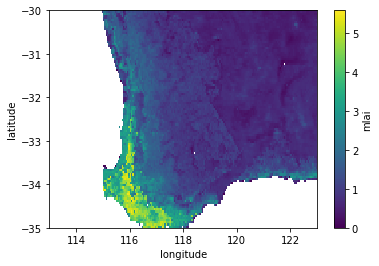

In [22]:
test2["mlai"].plot()

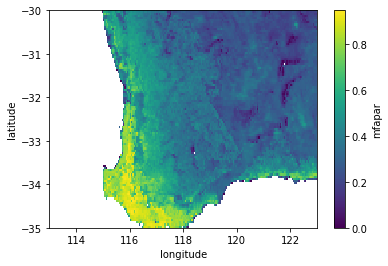

In [23]:
test2["mfapar"].plot()